Data Preprocessing

In [76]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

df = pd.read_csv('alzheimers_prediction_dataset copy.csv') 

df['Marital Status'] = df['Marital Status'].apply(
    lambda x: 'Married' if x in ['Married'] else 'Not Married'
)
df['Employment Status'] = df['Employment Status'].apply(
    lambda x: 'Employed' if x in ['Employed'] else 'Not Employed'
)

ordinal_features = ['Physical Activity Level', 'Smoking Status', 'Alcohol Consumption', 'Depression Level', 'Sleep Quality', 'Dietary Habits', 'Air Pollution Exposure', 'Social Engagement Level', 'Income Level', 'Stress Levels']
ordinal_categories = [
    ['Low', 'Medium', 'High'], # physical activity level
    ['Never', 'Former', 'Current'], # smoking status
    ['Never', 'Occasionally', 'Regularly'], # alcohol consumption
    ['Low', 'Medium', 'High'], # depression level
    ['Poor', 'Average', 'Good'], # sleep quality
    ['Unhealthy', 'Average', 'Healthy'], # dietary habit
    ['Low', 'Medium', 'High'], # air pollution exposure
    ['Low', 'Medium', 'High'], # social engagement level
    ['Low', 'Medium', 'High'], # income level
    ['Low', 'Medium', 'High'] # stress level
]
ordinal_encoder = OrdinalEncoder(categories=ordinal_categories)

binary_features = ['Gender', 'Diabetes', 'Hypertension', 'Cholesterol Level', 'Family History of Alzheimer’s', 'Employment Status', 'Marital Status', 'Genetic Risk Factor (APOE-ε4 allele)', 'Urban vs Rural Living']
binary_categories = [
    ['Male', 'Female'], #gender
    ['No', 'Yes'], # diabetes
    ['No', 'Yes'], # hypertension
    ['Normal', 'High'], # cholesterol level
    ['No', 'Yes'], # family history
    ['Not Employed', 'Employed'], # employment
    ['Not Married', 'Married'], # martial status
    ['No', 'Yes'], # generic factor
    ['Urban', 'Rural'] # urban vs rural
]
binary_encoder = OrdinalEncoder(categories=binary_categories)

num_features = ['Age', 'BMI', 'Cognitive Test Score' ]
preprocessor = ColumnTransformer(
    transformers=[
        ('bin', binary_encoder, binary_features),
        ('ord', ordinal_encoder, ordinal_features),
        ('num', StandardScaler(), num_features)
    ],
    remainder='drop'
)

data = preprocessor.fit_transform(df)

transformed_columns = binary_features + ordinal_features + num_features

processed_df = pd.DataFrame(data, columns=transformed_columns)


processed_df.head()

,Gender,Diabetes,Hypertension,Cholesterol Level,Family History of Alzheimer’s,Employment Status,Marital Status,Genetic Risk Factor (APOE-ε4 allele),Urban vs Rural Living,Physical Activity Level,...,Depression Level,Sleep Quality,Dietary Habits,Air Pollution Exposure,Social Engagement Level,Income Level,Stress Levels,Age,BMI,Cognitive Test Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,2.0,2.0,0.0,1.0,2.0,1.389398,1.305314,1.257660
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,2.0,2.0,1.0,2.0,0.0,2.0,0.002719,0.654689,0.017157
2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,...,2.0,2.0,1.0,1.0,0.0,1.0,2.0,1.081247,-0.814465,-1.074486
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,2.0,1.0,2.0,1.0,0.0,-1.460997,0.927532,0.811079
4,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,2.0,...,2.0,0.0,0.0,2.0,0.0,1.0,2.0,-1.075808,0.675677,-0.776765


Features selecting

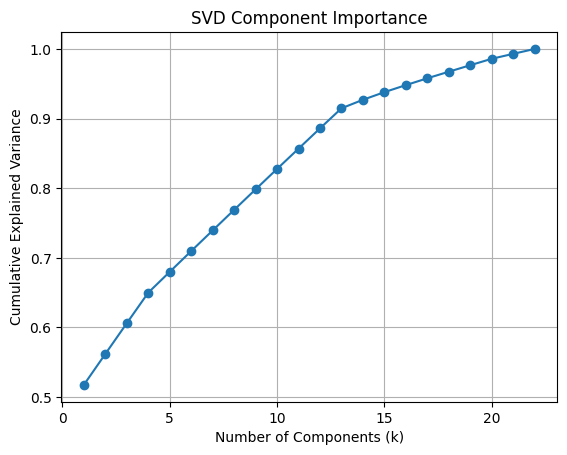

Chosen k = 13 (to retain ≥90% of the variance)


In [77]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

U,S,Vt = np.linalg.svd(processed_df, full_matrices=False)
explained_variance_ratio = (S**2) / np.sum(S**2)
cumulative_variance = np.cumsum(explained_variance_ratio)
plt.plot(range(1, len(S)+1), cumulative_variance, marker='o')
plt.xlabel('Number of Components (k)')
plt.ylabel('Cumulative Explained Variance')
plt.title('SVD Component Importance')
plt.grid(True)
plt.show()
k = np.argmax(cumulative_variance >= 0.9) + 1
print(f"Chosen k = {k} (to retain ≥90% of the variance)")




In [78]:
Vt_k = Vt[:k, :]
importance = np.mean(np.abs(Vt_k), axis=0)
feature_importance = pd.Series(importance, index=transformed_columns).sort_values(ascending=False)
n = 10 # num features selected 
print("Top", n, " features contributing to top", k, "SVD components:")
print(feature_importance.head(n))
selected_features = feature_importance.head(n).index.tolist()
feature_indices = [transformed_columns.index(name) for name in selected_features]
X_selected = data[:, feature_indices]
pd.DataFrame(X_selected, columns=selected_features).head()


Top 10  features contributing to top 13 SVD components:
Depression Level           0.224804
Income Level               0.218328
Sleep Quality              0.213137
Physical Activity Level    0.209934
Social Engagement Level    0.208816
Dietary Habits             0.208581
Smoking Status             0.205144
Air Pollution Exposure     0.197277
Alcohol Consumption        0.194984
Stress Levels              0.191782
dtype: float64


,Depression Level,Income Level,Sleep Quality,Physical Activity Level,Social Engagement Level,Dietary Habits,Smoking Status,Air Pollution Exposure,Alcohol Consumption,Stress Levels
0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,2.0,1.0,2.0
1,0.0,0.0,2.0,1.0,2.0,2.0,1.0,1.0,0.0,2.0
2,2.0,1.0,2.0,2.0,0.0,1.0,2.0,1.0,1.0,2.0
3,1.0,1.0,1.0,0.0,2.0,2.0,0.0,1.0,2.0,0.0
4,2.0,1.0,0.0,2.0,0.0,0.0,1.0,2.0,0.0,2.0


In [79]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

y = df['Alzheimer’s Diagnosis'].apply(lambda x: 1 if x == 'Yes' else 0).values
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# sm = SMOTE(random_state=42)
# X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
clf = RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=5, max_features=8, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", clf.score(X_test, y_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Accuracy: 0.5024567543918691

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.51      0.55      8719
           1       0.41      0.49      0.45      6138

    accuracy                           0.50     14857
   macro avg       0.50      0.50      0.50     14857
weighted avg       0.52      0.50      0.51     14857

